# FashionMNIST Classification with TinyVGG

**Objective**: Designed adn trained a lightweight convolutional neural network (TinyVGG) to classify FashionMNIST images, achieving **91.11% accuracy** while demonstrating core PyTorchh workflows, model optimisation, and evaluation

**Key Skills**:
1. PyTorch Proficiency: Model architecture design (nn.Module), data loading (DataLoader), and training loops

2. CNN Architecture: Implemented a multi-layer CNN with ReLU activations, max pooling, and linear classification

3. Research Best Practices: Hyperparameter tuning (batch size, learning rate), loss/accuracy tracking, and confusion matrix analysis

4. Reproducibility: Used fixed random seeds, modular functions for training/evaluation, and visualization tools (Matplotlib, mlxtend).

# PyTorch workflow

The workflow for this project starts off with
1. Getting the Data ready: In our case, we import the data from `torchvision datasets`, and transform it to a tensor. We then use a `dataloader` to create batches of size 32 for the train and test datasets

2. Build or Pick a Model: For our case, we decided to go for a `Baseline Model` of just the `flattener`, and the `linear layer`, and then built the `TinyVGG model architecture` on top of it. The typical structure of this is:

`Input Layer` -> [`Convolutional layer` -> `activation layer` -> `pooling layer`] -> `Output layer`

  Where the contents of the middle layers can be upscaled and repeated multiple times, but in our case, it is done only once

3. We pick the loss function of `Cross Entropy` since it is a Multi Class Classfication and for the optimiser we pick `Stochastic Gradient Descent` since its generalization performance is good (or better compared to `Adam` or `AdamW`).

4. We train the model through a loop. Starting off with 10 epochs for this test case, we put the model in `train mode`, do a `forward pass` and get the variables for prediction. Using the `loss function`, we quantify the difference betweent he actualy probability and the predicted probability. Then we `clear the gradients` of the parameters and do a `loss backward` and `fine tune the parameters` with the optimiser. We then evaluate it based on the `loss` and the `accuracy` of each epoch

5. For the evaluation of the model we make predictions to see the probability the model provides for each class for an image, and take the index of the maximum probability value, and `plot a graph` showing the predicted and the true value. Additionally, we use a `confusion matrix` to evaluate the number of true positives, false positives, true negatives, and false negatives, and where the data point was actually marked

In [ ]:
# dependencies
import torch
from torch import nn
from torch.utils.data import DataLoader
import random


import torchvision
from torchvision import datasets # the clothes dataset
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

import mlxtend
assert int(mlxtend.__version__.split(".")[1]) >= 19
from tqdm.auto import tqdm


mlxtend version: 0.23.4


The `FashionMNIST dataset` (60k grayscale images) is loaded with `ToTensor()` to convert PIL images to PyTorch tensors and normalized to [0, 1].

`DataLoader` shuffles training data to reduce batch bias and parallelizes loading

In [ ]:
# datasets
train = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

test = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [ ]:
len(train), len(test)

(60000, 10000)

In [ ]:
for i in range(10):
  print("for index", i, "the labels is", train.classes[i])
class_names = train.classes

for index 0 the labels is T-shirt/top
for index 1 the labels is Trouser
for index 2 the labels is Pullover
for index 3 the labels is Dress
for index 4 the labels is Coat
for index 5 the labels is Sandal
for index 6 the labels is Shirt
for index 7 the labels is Sneaker
for index 8 the labels is Bag
for index 9 the labels is Ankle boot


In [ ]:
image = train[0][0]
label = train[0][1]

image.shape, label # since it is grey scale, the color channel is 1

(torch.Size([1, 28, 28]), 9)

Text(0.5, 1.0, 'Ankle boot')

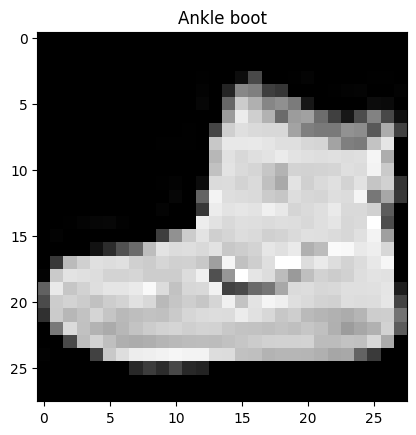

In [ ]:
# visualise to see whether it is a boot or not-
plt.imshow(image.squeeze(), cmap="gray") # remove one dimension ? - remove the color channel
plt.title(class_names[label])

In [ ]:
# need the dataloader for the batch size and the shuffle mode?

batch_size = 32 # usually people go for this number dk why

train_dataloader = DataLoader(batch_size=32, shuffle=True, dataset=train)
test_dataloader = DataLoader(test, 32, False)

In [ ]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape
# the batch, color channel, height, width
# label size

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'T-shirt/top')

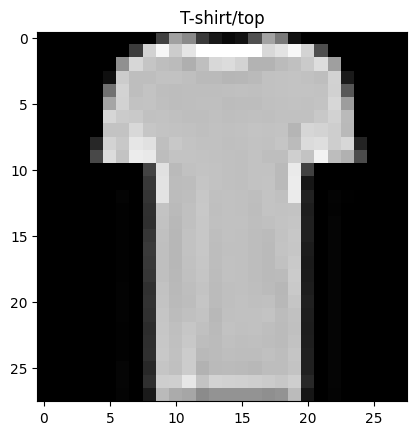

In [ ]:
image,label = next(iter(train_dataloader))
image = image[0][0].squeeze()
image = image.squeeze()

label = label[0]
label = class_names[label]

plt.imshow(image.squeeze(), cmap="gray") # remove one dimension why? - remove the color channel
plt.title(label)

The TinyVGG model has the following modules in it:
1. `Conv2d()`: Applying a 2D convolution over an input composed of several input planes. We use 2D since the gray scale images are two-dimensional data

2. `ReLu()`: This module introduces Non-Linearity as an activation function. It accelerates the convergence compared to sigmoid or tanh by mitigating vanishing gradients

3. `MaxPool2d()`: This module selects the maximm value within the specified window and discards the rest to reduce dimensionality and emphasise on the more prominent features; it shrinks the feature map size and preserves translational invariance

4. `Flatten()`: mulitplies the height and the width provided in the tensor to make it a one-dimensional vector, used for classification or regression


In [ ]:
# the baseline model
class BaselineModel(nn.Module): # TinyVGG model
  def __init__(self, input_dimensions, output_dimensions, nodes):
    super().__init__()

    self.firstLayer = nn.Sequential(
        nn.Conv2d(input_dimensions, nodes, 3, 1,1),
        nn.ReLU(),
        nn.Conv2d(in_channels=nodes, out_channels=nodes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # default stride is the same as the kernel size
    )

    self.secondLayer = nn.Sequential(
        nn.Conv2d(nodes, nodes, 3, 1,  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=nodes, out_channels=nodes, kernel_size=3, stride=1,  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # default stride is the same as the kernel size
    )

    self.lastLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(nodes*7*7, output_dimensions)
    )

  def forward(self, x):
    x = self.firstLayer(x)
    x = self.secondLayer(x)
    x = self.lastLayer(x)

    return x

For the **Loss function**, we use a *Cross Entropy Loss* `CrossEntropyLoss()` which is a standard for multi class classification along with *Stochastic Gradient Descent* `SGD()` with a high learning rate `lr=0.1` for faster convergence

We do not use `Adam` or `AdamW` since the dataset is not that big, and we would like to keep the baseline model simple. Additionally, since the dataset is small, `SGD` generalises marginally better than `Adam` or `AdamW` and using the latter owuld be overkill since it uses per-parameter scaling

In [ ]:
# loss function and optimiser
model0 = BaselineModel(1, len(class_names), 10)

lossFunction = nn.CrossEntropyLoss()
optimiserFunction = torch.optim.SGD(model0.parameters(), lr=0.1)

The accuracy function `accuracy_fn` sees how many predicted values are true values, and provides a percentage for it

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

The key highlights of the training loop are:

1. the Gradient Management with `optimiserFunction.zero_grad()` which prevents the accumulation between batches.

2. Additionally we track the metrics epoch-wise by calculating the `loss rate` and the `accuracy` with the accuracy function and the loss function `accuracy_fn` and `loss` respectively to diagnose underfitting

3. Finally we use the `inference_mode()` to disable gradient computation during testing to reduce memory overhead

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               ):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X, y

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
# testing loop
epochs = 10

for epoch in range(epochs):
  train_step(
      model0, train_dataloader, lossFunction, optimiserFunction, accuracy_fn
  )


Train loss: 0.58290 | Train accuracy: 78.74%
Train loss: 0.35710 | Train accuracy: 87.07%
Train loss: 0.32027 | Train accuracy: 88.46%
Train loss: 0.29958 | Train accuracy: 89.15%
Train loss: 0.28357 | Train accuracy: 89.74%
Train loss: 0.27026 | Train accuracy: 90.19%
Train loss: 0.26347 | Train accuracy: 90.32%
Train loss: 0.25926 | Train accuracy: 90.60%
Train loss: 0.25298 | Train accuracy: 90.79%
Train loss: 0.24648 | Train accuracy: 91.11%


In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [ ]:
# evaluation
model_0_results = eval_model(model=model0, data_loader=test_dataloader,
    loss_fn=lossFunction, accuracy_fn=accuracy_fn
)

model_0_results

{'model_name': 'BaselineModel',
 'model_loss': 0.28611522912979126,
 'model_acc': 89.82627795527156}

To visualise the data points, we take the probability of the predictions. For this, we using the `logit values` from the model and using `softmax`, ensure that the sum of the values equal 1 to simalute a probability out of 1.

Using this probability, we take the `maximum value` as the predicted value and compare it to the true value using a `graph` for visual representation.

We also use a `Confusion Matrix` and `mlxtend` to plot the confusion matrix with the probability data points we acquired

In [ ]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension and send sample to device

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [ ]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 1 (Trouser)


In [ ]:
pred_probs= make_predictions(model=model0,
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

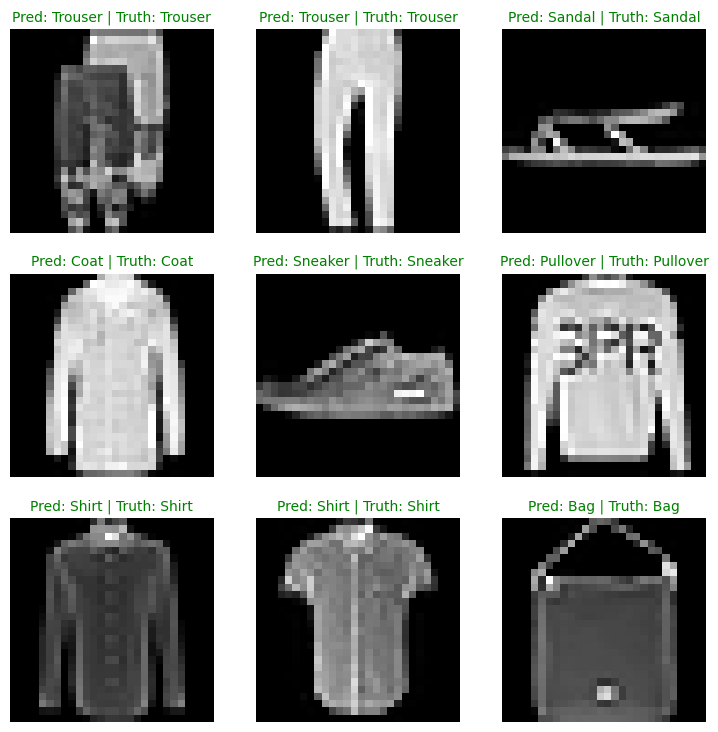

In [ ]:
# visualise

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [ ]:
y_preds = []
model0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X, y
    # Do the forward pass
    y_logit = model0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

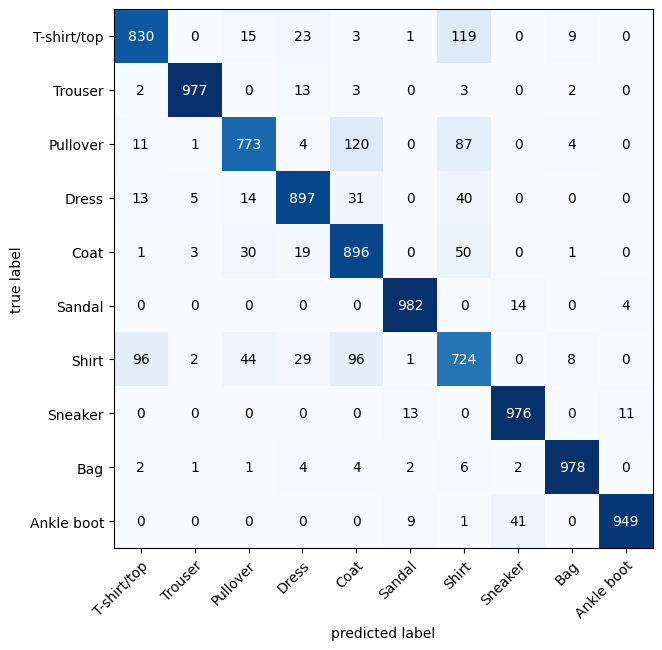

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);